<h1>Solving Kaggle's Cats vs Dogs with Theano and Lasagne</h1>

<h2>Summary</h2>

The dataset consists of 25000 labeled RGB .jpg images of cats and dogs of various resolutions. <br>

As a start, I decided to transform the original images into 100x100 grayscale images and train a small convnet on them. The resulting test error was approximately 11.8%.

After that I decided to try several larger models with RGB images, but for some reason for all models the validation accuracy raised to about 72% and started to decline with more epochs. After spending several days trying to fix the model and studying the methods to increase the convnet performance, to my frustration I found an error in dataset preparation: I did not transpose the images before reshaping them. Fixing this error resulted in the ~11.5% validation errors for the large models.

Paths further improve the result:

* Using larger images
* Adding more noise, distorted/rotated images
* Pretraining with unlabeled images
* Using existing pre-trained networks for feature extraction

As I understood from Kaggle forums, the absolute majority of people who got over 94% accuracy and all of the top 5 used pretrained models such as Decaf Imagenet or AlexNet with their own classifier on top. This approach is something I consider trying next.


<h2>The screenshot of Kaggle submission:</h2> <br>


<img src="Screenshot_submission.png">

<h2>Functions for data preparation</h2>

In [25]:
import sys
import os
import csv
import numpy as np
import Image
import ImageOps
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pylab



# Convert all the image files in the given path into np arrays with dimensions suitable for DL with Theano
def jpg_to_nparray(path, img_size, grayscale = False):
    X = []
    Y = []
    counter = 0
    img_colors = 3

    for img_dir in os.listdir(path):

        # X
        img = Image.open(path+img_dir)
        img = ImageOps.fit(img, (img_size, img_size), Image.ANTIALIAS)
        
        if grayscale:
            img = ImageOps.grayscale(img)
            img_colors = 1


        img = np.asarray(img, dtype = 'float32') / 255.
        img = img.transpose(2,0,1).reshape(img_colors, img_size, img_size)
        X.append(img)

        # Y: 0 for cat, 1 for dog
        if "cat" in img_dir:
            Y.append(0)
        else:
            Y.append(1)


        # Printing
        counter+=1
        if counter%6000 == 0:
            print'processed images: ', counter

    X = np.asarray(X)
    Y = np.asarray(Y,dtype='int32')

    return (X,Y)



# Get ids of the images: we'll need them for generating the submission file for Kaggle
def get_ids(path):
    ids = np.array([],dtype = int)
    for str in os.listdir(path):
        ids = np.append(ids, int(str.partition(".")[0]))
    
    ids = np.array(ids, dtype = int)[...,None]
    return ids


        
# Makes labeled training, validation and test sets, 
# as well as the unlabeled dataset for Kaggle evaluation
# As it takes some time and lots of memory, it is possible
# to make the labeled and unlabeled datasets separately.
def make_datasets(img_size, grayscale = False, labeled = "labeled"):

    train_path = '/media/dima/Data/DATA_DL/cats_vs_dogs/train/'
    unlabeled_path = '/media/dima/Data/DATA_DL/cats_vs_dogs/test1/'

    if (labeled == "labeled" or labeled == "all"):
        print 'Prosessing labeled images'

        X_train, Y_train = jpg_to_nparray(train_path, img_size, grayscale)

        # Patrtition into labeled training, validation and test sets
        # Shuffle the examples, because they are in order in the original dataset with all cats being first
        rng_state = np.random.get_state()
        np.random.shuffle(X_train)
        np.random.set_state(rng_state)
        np.random.shuffle(Y_train)


        X_val = X_train[0:2999]
        Y_val = Y_train[0:2999]
        X_test = X_train[3000:4999]
        Y_test = Y_train[3000:4999]
        X_train = X_train[5000:24999]
        Y_train = Y_train[5000:24999]
    
        pickle.dump((X_train, Y_train, X_val, Y_val, X_test, Y_test), 
                    open('/media/dima/Data/DATA_DL/cats_vs_dogs/datasets_labeled_100.pkl','wb'))
    
    if (labeled == "unlabeled" or labeled == "all"):
        print 'Prosessing unlabeled images'

        X_unlabeled, Y_unlabeled = jpg_to_nparray(unlabeled_path, img_size, grayscale)

        pickle.dump((X_unlabeled, Y_unlabeled), 
                    open('/media/dima/Data/DATA_DL/cats_vs_dogs/datasets_unlabeled_100.pkl','wb'))

<h2>Plotting one of the original pictures and the same picture after transformation</h2>


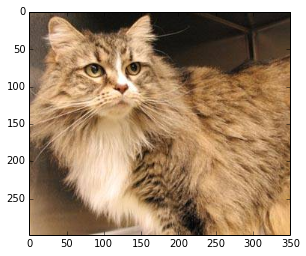

In [166]:
path = ('/media/dima/Data/DATA_DL/cats_vs_dogs/train/')
img = Image.open(path+os.listdir(path)[111])
plt.imshow(img)
plt.show()

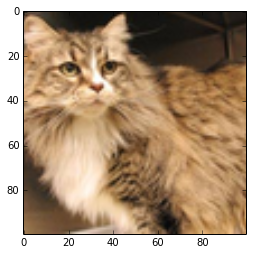

In [167]:
img = ImageOps.fit(img, (100, 100), Image.ANTIALIAS)
plt.imshow(img)
plt.show()

<h2>Function for initializing the convnet</h2>



Convnet architecture:

* Input: 3x100x100
* Conv: 64   8x8 filters MaxPool: 2x2
* Conv: 128  6x6 filters MaxPool: 2x2
* Conv: 128  6x6 filters MaxPool: 2x2
* Conv: 128  6x6 filters
* Conv: 256  4x4 filters MaxPool: 2x2, 5% dropout
* Conv: 256  4x4 filters, 10% dropout

* Fully-connected: 600 units, 20% dropout
* Output: 2 units, 30% dropout

"Same" padding is used at every convolution layer.


In [26]:
import theano
import theano.tensor as T
import time
import lasagne

def build_cnn(input_var=None):

    # Input layer:
    input_layer = lasagne.layers.InputLayer(shape=(None, 3, 100, 100),
                                        input_var=input_var)

    # Convolutional layer with 64 kernels of size 8x8. 
    conv_1 = lasagne.layers.Conv2DLayer(
            input_layer, num_filters=64, filter_size=(8, 8), pad = 'same',
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    # Max-pooling layer of factor 2 in both dimensions:
    pool_1 = lasagne.layers.MaxPool2DLayer(conv_1, pool_size=(2, 2))


    # Convolution with 128 6x6 kernels:
    conv_2 = lasagne.layers.Conv2DLayer(
            pool_1,
            num_filters=128, filter_size=(6, 6), pad = 'same',
            nonlinearity=lasagne.nonlinearities.rectify)

    
    
    # Max-pooling layer of factor 2 in both dimensions:
    pool_2 = lasagne.layers.MaxPool2DLayer(conv_2, pool_size=(2, 2))
    
    
    # Convolution with 128 6x6 kernels:
    conv_3 = lasagne.layers.Conv2DLayer(
            pool_2, num_filters=128, filter_size=(6, 6), pad = 'same',
            nonlinearity=lasagne.nonlinearities.rectify)


    # Max-pooling layer of factor 2 in both dimensions:
    pool_3 = lasagne.layers.MaxPool2DLayer(conv_3, pool_size=(2, 2))
    


    # Convolution with 128 4x4 kernels:
    conv_4 = lasagne.layers.Conv2DLayer(
            pool_3,
            num_filters=128, filter_size=(6, 6), pad = 'same',
            nonlinearity=lasagne.nonlinearities.rectify)


    # Convolution with 256 4x4 kernels:
    conv_5 = lasagne.layers.Conv2DLayer(
            lasagne.layers.dropout(conv_4, p=.05),
            num_filters=256, filter_size=(4, 4), pad = 'same',
            nonlinearity=lasagne.nonlinearities.rectify)


    # Max-pooling layer of factor 2 in both dimensions:
    pool_4 = lasagne.layers.MaxPool2DLayer(conv_5, pool_size=(2, 2))


    
    # Convolution with 256 3x3 kernels:
    conv_6 = lasagne.layers.Conv2DLayer(
            lasagne.layers.dropout(pool_4, p=.1),
            num_filters=256, filter_size=(4, 4), pad = 'same',
            nonlinearity=lasagne.nonlinearities.rectify)  


    # A fully-connected layer of 600 units with 30% dropout on its inputs:
    dense_layer = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(conv_6, p=.2),
            num_units=600,
            nonlinearity=lasagne.nonlinearities.rectify)


    # The 2-unit output layer with 50% dropout on its inputs:
    output_layer = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(dense_layer, p=.3),
            num_units=2,
            nonlinearity=lasagne.nonlinearities.softmax)

    return output_layer


<h2>Training the network and making predictions on Kaggle dataset</h2>

The large network above network has been trained for 36 epochs with learning rate = 0.005, and then further 22 epochs with learning rate = 0.0015. Each epoch took approximately 18 minutes with GTX850M laptop GPU, the network converged with ~11.5% validation error and 11.9% test error. L2 regularization was used with alpha = 0.0003.

The code for training the network relies heavily on the <a href="http://lasagne.readthedocs.org/en/latest/user/tutorial.html#run-the-mnist-example">
lasagne MNIST tutorial</a>.

In [157]:
# A function from Lasagne MNIST tutorial for iterating minibatches of a given size
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]



def train_model(num_epochs=0, make_predictions = False):
    
    # Load the dataset
    print("Loading data...")
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(
        open(os.path.abspath('/media/dima/Data/DATA_DL/cats_vs_dogs/datasets_labeled_100.pkl'),'rb'))

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')

    # Initialize the model
    print("Building model and compiling functions...")
    network = build_cnn(input_var)
    

    # Create a loss expression for training
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    
    # Create L2 regularization and add it lo loss
    l2_regularization = lasagne.regularization.regularize_network_params(network, 
                                                                         lasagne.regularization.l2, 
                                                                         tags={'regularizable': True})*0.0003
    loss = loss + l2_regularization

    # Create update expressions for training
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.0015, momentum=0.8)

    # Create a loss expression for validation/testing. 
    # We do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    test_loss = test_loss + l2_regularization
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates,  allow_input_downcast=True)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

    # Compile a function for predicting unclassified images
    get_prediction = theano.function([input_var], [test_prediction])

    
    # Load saved weights
    with np.load('cat_dog_100x100_colored_network_02_large.npz') as f:
         param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)

    batch_size = 64
    
    # The training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1
    
        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1
    
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
        
        # Save weights every 5 epochs
        if (epoch%2 == 0):
            np.savez('cat_dog_100x100_colored_network_02_large.npz', 
                     *lasagne.layers.get_all_param_values(network))



    # Compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))



    if make_predictions:
        
        # Load the dataset
        print("Loading data...")
        X_unlabeled, y_unlabeled = pickle.load(
        open(os.path.abspath('/media/dima/Data/DATA_DL/cats_vs_dogs/datasets_unlabeled_100.pkl'),'rb'))

        predictions = np.array([],dtype = int)
        # Make predictions
        for batch in iterate_minibatches(X_unlabeled, y_unlabeled, batch_size, shuffle=False):
            inputs, targets = batch
            batch_predictions = np.array(get_prediction(inputs)).reshape(batch_size,2)
            batch_predictions = batch_predictions[:,1]>batch_predictions[:,0] 
            batch_predictions = np.array(batch_predictions, dtype= int)
            predictions = np.append(predictions, batch_predictions)
        predictions = np.array(predictions, dtype = int)[...,None]

        unlabeled_path = os.path.abspath('/media/dima/Data/DATA_DL/cats_vs_dogs/test1/')
        submission_ids = get_ids(unlabeled_path)

        submission_array = (np.append(submission_ids, predictions,axis = 1))
        np.savetxt("submission.csv", submission_array,  fmt='%d', delimiter=',', 
                   newline='\n', header='id,label', comments = '')
        print("Submission file saved")



    # Save the network weights to a file:
    np.savez('cat_dog_100x100_colored_network_02_large.npz', 
             *lasagne.layers.get_all_param_values(network))

    

if __name__ == '__main__':
    #make_datasets(100, grayscale = False)
    train_model(num_epochs = 0, make_predictions= False)

Loading data...
Building model and compiling functions...
Starting training...
Final results:
  test loss:			1.109651
  test accuracy:		88.10 %


<h2>Plotting feature maps and filters</h2>


In [27]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')
    
# Get an image
image, y = jpg_to_nparray('/media/dima/Data/DATA_DL/cats_vs_dogs/for_visualization/', 100)
    
# Initialize the model
network = build_cnn(input_var)
    
# Load saved weights
with np.load('cat_dog_100x100_colored_network_02_large.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)

# Get output of the network after the filters of the first conv layer are applied
get_output = lasagne.layers.get_output(lasagne.layers.get_all_layers(network)[1], image)
output = get_output.eval()

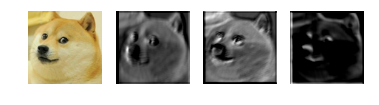

In [28]:
# Plot the original image
pylab.subplot(1, 4, 1); 
pylab.axis('off'); 
pylab.imshow(image[0, :, :, :].transpose(1,2,0).reshape(100,100,3))
pylab.gray();

# Plot 3 random feature maps
pylab.subplot(1, 4, 2); pylab.axis('off'); pylab.imshow(output[0, 3, :, :])
pylab.subplot(1, 4, 3); pylab.axis('off'); pylab.imshow(output[0, 4, :, :])
pylab.subplot(1, 4, 4); pylab.axis('off'); pylab.imshow(output[0, 25, :, :])
pylab.show()

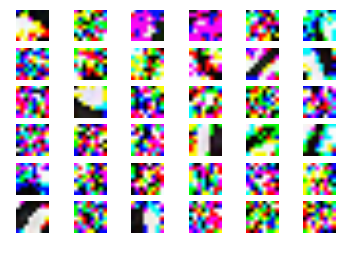

In [29]:
# Plot first 36 filters of the first conv layer
for i in range(36):    
    pylab.subplot(6, 6, i); 
    pylab.axis('off'); 
    pylab.imshow(np.asarray(param_values[0][i, :, :, :]).transpose(1,2,0).reshape(8,8,3))